In [ ]:
!pip install pandas_ta pygad

In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import pandas_ta as ta
import pygad
import pygad.kerasga
import matplotlib.pyplot as plt

from gym import spaces
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import datetime

In [ ]:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

# Download data
print(f'Downloading OIH_adjusted.txt...')
urlretrieve('http://api.kibot.com/?action=history&symbol=OIH&interval=1&unadjusted=0&bp=1&user=guest', 'OIH_adjusted.txt')

# Read data and assign names to the columns
df = pd.read_csv('OIH_adjusted.txt')
df.columns = ['date','time','open','high','low','close','volume']

# Combine date and time in the date column
df['date'] = df['date'] + ' ' + df['time']
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y %H:%M')
df = df[['date','open','high','low','close','volume']]

# Sort by date and assign the date as index
df = df.sort_values('date').reset_index(drop=True).set_index('date')

# Convert the data to different timeframes & save them for future uses
AGGREGATION = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
TIMEFRAMES = ['1H']

for timeframe in TIMEFRAMES:
    print(f'Converting & Saving {timeframe} Data...')
    df = df.resample(timeframe).agg(AGGREGATION).dropna()
    df.to_csv(f'OIH_{timeframe}.csv.gz', compression='gzip')


Converting & Saving 1H Data...


/tmp/ipython-input-3662036187.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample(timeframe).agg(AGGREGATION).dropna()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
print(df)

                       open     high      low    close  volume
date                                                          
2001-02-26 09:00:00  406.24  407.890  406.240  407.890     212
2001-02-26 10:00:00  411.91  417.120  411.910  417.120    6534
2001-02-26 11:00:00  414.85  420.190  414.850  417.920    1522
2001-02-26 12:00:00  420.90  422.080  420.900  422.080     275
2001-02-26 13:00:00  421.61  421.700  421.370  421.610     506
...                     ...      ...      ...      ...     ...
2022-10-14 12:00:00  243.37  245.130  242.760  243.470   56668
2022-10-14 13:00:00  243.60  243.920  241.600  242.965   49162
2022-10-14 14:00:00  242.61  242.820  240.200  240.440   42467
2022-10-14 15:00:00  240.90  241.205  239.765  239.960   71906
2022-10-14 16:00:00  239.99  241.640  239.990  239.990   19557

[54299 rows x 5 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


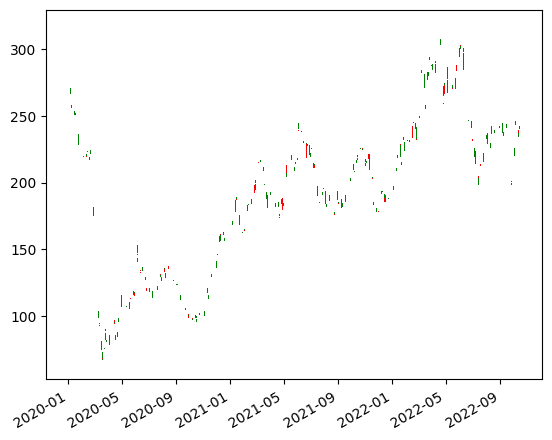

In [ ]:
# Define start/end window
start = pd.Timestamp("2020-01-01")
end   = pd.Timestamp("2022-12-31")

# Slice both up and down with the same date window
df = df.loc[(df.index >= start) & (df.index <= end)]

up = df[df.close >= df.open]
down = df[df.close < df.open]

moving_avg = df.rolling(window=5).mean()
moving_avg_rough = df.rolling(window=20).mean()

# When the stock prices have decreased, then it
# will be represented by red color candlestick
col1 = 'red'

# When the stock prices have increased, then it
# will be represented by green color candlestick
col2 = 'green'

width = .3
width2 = .03

# Plotting up prices of the stock
plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)

# Plotting down prices of the stock
plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')

# displaying candlestick chart of stock data
plt.show()

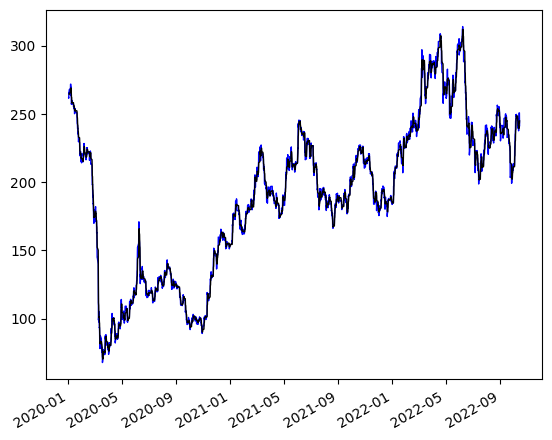

In [ ]:
plt.plot(moving_avg.index, moving_avg.close, color='blue', linewidth=1)
plt.plot(moving_avg_rough.index, moving_avg_rough.close, color='black', linewidth=1)
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
plt.show()

In [ ]:
# Operations
SELL = 0
HOLD = 1
BUY = 2

class SellHoldBuyEnv(gym.Env):

    def __init__(self, observation_size, features, closes):

        # Data
        self.__features = features
        self.__prices = closes

        # Spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(observation_size,), dtype=np.float32)
        self.action_space = spaces.Discrete(3)

        # Episode Management
        self.__start_tick = observation_size
        self.__end_tick = len(self.__prices)
        self.__current_tick = self.__end_tick

        # Position Management
        self.__current_action = HOLD
        self.__current_profit = 0
        self.__wins = 0
        self.__losses = 0

    def reset(self):

        # Reset the current action and current profit
        self.__current_action = HOLD
        self.__current_profit = 0
        self.__wins = 0
        self.__losses = 0

        # Reset the current tick pointer and return a new observation
        self.__current_tick = self.__start_tick

        return self.__get_observation()

    def step(self, action):

        # If current tick is over the last index in the feature array, the environment needs to be reset
        if self.__current_tick > self.__end_tick:
            raise Exception('The environment needs to be reset.')

        # Compute the step reward (Penalize the agent if it is stuck doing anything)
        step_reward = 0
        if self.__current_action == HOLD and action == BUY:
            self.__open_price = self.__prices[self.__current_tick]
            self.__current_action = BUY
        elif self.__current_action == BUY and action == SELL:
            step_reward = self.__prices[self.__current_tick] - self.__open_price
            self.__current_profit += step_reward
            self.__current_action = HOLD

            if step_reward > 0:
                self.__wins += 1
            else:
                self.__losses += 1

        # Generate the custom info array with the real and predicted values
        info = {
            'current_action': self.__current_action,
            'current_profit': self.__current_profit,
            'wins': self.__wins,
            'losses': self.__losses
        }

        # Increase the current tick pointer, check if the environment is fully processed, and get a new observation
        self.__current_tick += 1
        done = self.__current_tick >= self.__end_tick
        obs = self.__get_observation()

        # Returns the observation, the step reward, the status of the environment, and the custom information
        return obs, step_reward, done, info

    def __get_observation(self):

        # If current tick over the last value in the feature array, the environment needs to be reset
        if self.__current_tick >= self.__end_tick:
            return None

        # Generate a copy of the observation to avoid changing the original data
        obs = self.__features[(self.__current_tick - self.__start_tick):self.__current_tick]

        # Return the calculated observation
        return obs


In [ ]:
# Constants
OBS_SIZE = 32
FEATURES = 2
SOLUTIONS = 20
GENERATIONS = 50

In [ ]:
print(df.columns.tolist())

['open', 'high', 'low', 'close', 'volume']


In [ ]:
# Loading data, and split in train and test datasets
df = pd.read_csv('OIH_1H.csv.gz', compression='gzip')
df.ta.bbands(close=df['close'], length=20, append=True)
df = df.dropna()
pd.options.mode.chained_assignment = None

df['high_limit'] = df['BBU_20_2.0_2.0'] + (df['BBU_20_2.0_2.0'] - df['BBL_20_2.0_2.0']) / 2
df['low_limit'] = df['BBL_20_2.0_2.0'] - (df['BBU_20_2.0_2.0'] - df['BBL_20_2.0_2.0']) / 2
df['close_percentage'] = np.clip((df['close'] - df['low_limit']) / (df['high_limit'] - df['low_limit']), 0, 1)
df['volatility'] = df['BBU_20_2.0_2.0'] / df['BBL_20_2.0_2.0'] - 1

train = df[df['date'] < '2022-01-01']
test = df[df['date'] >= '2022-01-01']

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def predict(X, W):
    X      = X.reshape((X.shape[0],-1))           #Flatten
    X      = X @ W[0] + W[1]                      #Dense
    X[X<0] = 0                                    #Relu
    X      = X @ W[2] + W[3]                      #Dense
    X[X<0] = 0                                    #Relu
    X      = X @ W[4] + W[5]                      #Dense
    X      = np.exp(X)/np.exp(X).sum(1)[...,None] #Softmax
    return X

In [ ]:
# Define fitness function to be used by the PyGAD instance
def fitness_func(self, solution, sol_idx):

    global model, observation_space_size, env

    # Set the weights to the model
    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
    model.set_weights(weights=model_weights_matrix)

    # Run a prediction over the train data
    observation = env.reset()
    total_reward = 0

    done = False
    while not done:
        state = np.reshape(observation, [1, observation_space_size])
        #q_values = model.predict(state, verbose=0)
        q_values = predict(state, model_weights_matrix)
        action = np.argmax(q_values[0])
        observation, reward, done, info = env.step(action)
        total_reward += reward

    # Print the reward and profit
    print(f"Solution {sol_idx:3d} - Total Reward: {total_reward:10.2f} - Profit: {info['current_profit']:10.3f}")

    if sol_idx == (SOLUTIONS-1):
        print("".center(60, "*"))

    # Return the solution reward
    return total_reward

In [ ]:
# Create a train environmant
env = SellHoldBuyEnv(observation_size=OBS_SIZE, features=train[['close_percentage','volatility']].values, closes=train['close'].values)
observation_space_size = env.observation_space.shape[0] * FEATURES
action_space_size = env.action_space.n

# Create Model
model = Sequential()
model.add(Dense(16, input_shape=(observation_space_size,), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(action_space_size, activation='linear'))
model.summary()

# Create Genetic Algorithm
keras_ga = pygad.kerasga.KerasGA(model=model, num_solutions=SOLUTIONS)

ga_instance = pygad.GA(num_generations=GENERATIONS,
                       num_parents_mating=5,
                       initial_population=keras_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       keep_parents=-1)

# Run the Genetic Algorithm
ga_instance.run()

# Show details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Fitness value of the best solution = {solution_fitness}")
print(f"Index of the best solution : {solution_idx}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,363 (5.32 KB)

 Trainable params: 1,363 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/pygad/kerasga/kerasga.py:26: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  vector = numpy.reshape(l_weights, newshape=(l_weights.size))


Solution   0 - Total Reward:     -60.52 - Profit:    -60.520
Solution   1 - Total Reward:    -213.95 - Profit:   -213.951
Solution   2 - Total Reward:       0.00 - Profit:      0.000
Solution   3 - Total Reward:       0.00 - Profit:      0.000
Solution   4 - Total Reward:      72.80 - Profit:     72.795
Solution   5 - Total Reward:     389.32 - Profit:    389.319
Solution   6 - Total Reward:       0.00 - Profit:      0.000
Solution   7 - Total Reward:       0.00 - Profit:      0.000
Solution   8 - Total Reward:       0.00 - Profit:      0.000
Solution   9 - Total Reward:       1.03 - Profit:      1.029
Solution  10 - Total Reward:       0.00 - Profit:      0.000
Solution  11 - Total Reward:       0.00 - Profit:      0.000
Solution  12 - Total Reward:      15.01 - Profit:     15.010
Solution  13 - Total Reward:     -20.68 - Profit:    -20.676
Solution  14 - Total Reward:       0.00 - Profit:      0.000
Solution  15 - Total Reward:       0.00 - Profit:      0.000
Solution  16 - Total Rew

In [ ]:
# Create a test environmant
env = SellHoldBuyEnv(observation_size=OBS_SIZE, features=test[['close_percentage','volatility']].values, closes=test['close'].values)

# Set the weights of the best solution to the model
best_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=solution)
model.set_weights(weights=best_weights_matrix)

# Run a prediction over the test data
observation = env.reset()
total_reward = 0

done = False
while not done:
    state = np.reshape(observation, [1, observation_space_size])
    #q_values = model.predict(state, verbose=0)
    q_values = predict(state, best_weights_matrix)
    action = np.argmax(q_values[0])
    observation, reward, done, info = env.step(action)
    total_reward += reward

/usr/local/lib/python3.12/dist-packages/pygad/kerasga/kerasga.py:60: DeprecationWarning: `newshape` keyword argument is deprecated, use `shape=...` or pass shape positionally instead. (deprecated in NumPy 2.1)
  layer_weights_matrix = numpy.reshape(layer_weights_vector, newshape=(layer_weights_shape))
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Show the final result
print(' RESULT '.center(60, '*'))
print(f"* Profit/Loss: {info['current_profit']:6.3f}")
print(f"* Wins: {info['wins']} - Losses: {info['losses']}")
print(f"* Win Rate: {100 * (info['wins']/(info['wins'] + info['losses'])):6.2f}%")

************************** RESULT **************************
* Profit/Loss: 31.884
* Wins: 64 - Losses: 55
* Win Rate:  53.78%


<Sequential name=sequential, built=True>


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,363 (5.32 KB)

 Trainable params: 1,363 (5.32 KB)

 Non-trainable params: 0 (0.00 B)

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 64), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 16, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'register

In [41]:
def run_and_plot(model, weight_vector, env, observation_size, closes):
    # Restore model weights
    weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model, weights_vector=weight_vector)
    model.set_weights(weights_matrix)

    obs = env.reset()
    done = False
    actions = []
    rewards = []
    step = 0
    total_reward = 0

    while not done:
        state = np.reshape(obs, [1, observation_size])
        q_values = predict(state, weights_matrix)
        action = np.argmax(q_values[0])
        obs, reward, done, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        total_reward += reward
        step += 1

    # Map to readable
    action_map = {0: "Sell", 1: "Hold", 2: "Buy"}
    actions_named = [action_map[a] for a in actions]

    # Align closes with actions
    closes_used = closes[env._SellHoldBuyEnv__start_tick:env._SellHoldBuyEnv__end_tick]

    df = pd.DataFrame({
        "Close": closes_used[:len(actions)],
        "Action": actions_named,
        "Reward": rewards
    })

    # Plot
    plt.figure(figsize=(14,6))
    plt.plot(df.index, df["Close"], color="black", label="Close")

    buy_idx = df.index[df["Action"]=="Buy"]
    sell_idx = df.index[df["Action"]=="Sell"]
    hold_idx = df.index[df["Action"]=="Hold"]

    plt.scatter(buy_idx, df.loc[buy_idx,"Close"], marker="^", color="green", label="Buy", s=80)
    plt.scatter(sell_idx, df.loc[sell_idx,"Close"], marker="v", color="red",   label="Sell", s=80)
    plt.scatter(hold_idx, df.loc[hold_idx,"Close"], marker="o", color="blue",  label="Hold", s=30, alpha=0.4)

    plt.title("Model Trading Actions")
    plt.xlabel("Time Step")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Total reward:", total_reward)
    return df


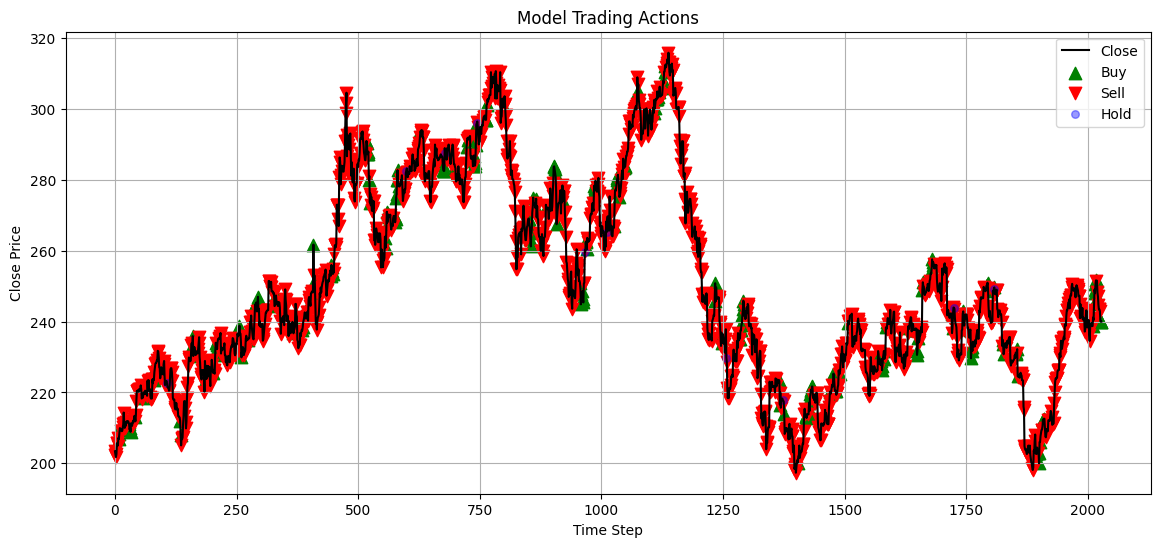

Total reward: 31.883799999999724


In [43]:
df_actions = run_and_plot(model, solution, env, observation_space_size, test["close"].values)